<a href="https://colab.research.google.com/github/anajikadam/Clinical-Trial-Search-Engine/blob/main/Medical_Embeddings_StreamlitApp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Streamlit App (Refer medical.py file to run the app)



## Generate ```requirements.txt```

- Install
    - ```pip install pipreqs```
    - ```pip install nbconvert```
    
- Convert your jupyter notebook to ```.py``` file
    - ```jupyter nbconvert --output-dir="./reqs" --to script notebook_name.ipynb```
    - ```cd reqs``` (Navigate to the .py file directory)

- Run the foloowing command in ```.py``` file folder
    - ```pipreqs "file_path"```
    - ```pipreqs --encoding=utf8 "file_path"``` (if above does not works)

Steps

- Run `medical.py` to see the app

In [ ]:
# !pip install streamlit
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
import streamlit as st

In [ ]:
%%writefile app1.py

import streamlit as st
st.write('# Streamlit calculator')
number1= st.number_input('number 1')
number2 = st.number_input('number 2')
print(number1, number2)
num3 = number1+number2
print(num3)
st.write('# Answer is ',num3)


Overwriting app1.py


In [ ]:
# get public IP

!wget -q -O - ipv4.icanhazip.com

34.125.222.16


In [ ]:
!streamlit run app1.py & npx localtunnel --port 8501

In [ ]:
%%writefile app.py

import os
import streamlit as st

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

import gensim
from gensim.models import Word2Vec, FastText

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go

import string # used for preprocessing
import re # used for preprocessing

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords       # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
# nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


df = pd.read_csv("/content/inputData_Dimension-covid.csv")

df1 = df.copy()


# lower-case the text
def text_lowercase(text: str):
    return text.lower()


# remove any urls in the text(if present)
def remove_urls(text: str):


    pattern = "(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"
    new_text = " ".join(re.sub(pattern, " ", text, flags=re.MULTILINE).split())

    return new_text


# remove any numbers
def remove_numbers(text: str):
    new_text = re.sub(r'\d+', '', text)
    return new_text

# remove any puntuations
def remove_punctuation(text: str):
    translator = str.maketrans('', '', string.punctuation)

    return text.translate(translator)


# tokenize
def tokenize(text: str):
    text = word_tokenize(text)
    return text

# remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text: str):
    # text = [word for word in text if word not in stop_words]
    text = [word for word in text if not word in stop_words]
    return text


# lemmatize Words
lemmatizer = WordNetLemmatizer()
def lemmatize(text: str):
    text = [lemmatizer.lemmatize(token) for token in text]
    return text

# Preprocessing
def preprocessing(text: str):
    # text = text.strip()

    # lower-case the text
    text = text_lowercase(text)

    # remove any urls in the text(if present)
    text = remove_urls(text)

    # remove any numbers
    text = remove_numbers(text)

    # remove any puntuations
    text = remove_punctuation(text)

    # tokenize
    text = tokenize(text)

    # remove stopwords
    text = remove_stopwords(text)

    # lemmatize
    text = lemmatize(text)

    text = " ".join(text)
    return text



skipgram = Word2Vec.load('/content/skipgram_100.bin')
fasttext = Word2Vec.load('/content/fast_text_100.bin')


vector_size = 100 # defining vectorf size for each word


def get_mean_vector(model, words):
    # remove out-of-vocabulary words
    words = [word for word in tokenize(words) if word in list(model.wv.index_to_key)] # if word in model vocab
    if len(words) > 0:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.array([0]*vector_size)




# Loading our pretrained vectors of each abstract
K = pd.read_csv('/content/skipgram-vec.csv')

# transforming dataframe into required array like structure as we did in above step
skipgram_vectors = []

for i in range(df1.shape[0]):
    skipgram_vectors.append(K[str(i)].values)



#Loading our pretrained vectors of each abstract
data = pd.read_csv('/content/fastText-vec.csv')

#transforming dataframe into required array like structure as we did in above step
fast_vectors = []

for i in range(df.shape[0]):
    fast_vectors.append(data[str(i)].values)



from numpy.linalg import norm
from numpy import dot


def cos_sim(a,b):
    """
    In our context:
        a: Vector 'a' represents emebedding/vector rep. of query passed
        b: The average vector of each abstract in our dataset

        So, we need to find cosine dist. b/w then to see how similar they are.
    """
    return dot(a,b)/(norm(a)*norm(b))



def main():
    # Load the data and model
    data = df


    # title of our app
    st.title("Clinical Trial Search Engine")
    # text below title
    st.write("Select Model")

    Vectors = st.selectbox("Model", options=['SkipGram', "FastText"])

    if Vectors=='SkipGram':
        K = skipgram_vectors
        model = skipgram
    else:
        K = fast_vectors
        model = fasttext

    # Get input from user
    st.write("Type your query here")

    query = st.text_input("Search Box")

    st.write("Number of results you expect")
    n = st.number_input("Enter n")


    def preprocessing_input(query, model):
        """
        We are providing query to analyze and the trained model to get it's vector rep.
        """
        query = preprocessing(query)
        query = query.replace("\n", ' ')
        K = get_mean_vector(model, query)

        return K


    def top_n(n, query, model, abs_vectors, df):
        """
        Function to return top n similar results

        n - to get top n
        query - input query
        model - trained model
        abs_vectors - average vectors for all abstracts obtained from the model
        df - original dataset
        """
        # n = int(input("Enter a integer value for n: "))
        print("\nQuery:",query,"\n")

        query = preprocessing_input(query, model)

        # Converting cosine similarities of overall dataset with i/p querie(s) into List
        query_cos_sim = []

        for idx,abs_vec in enumerate(abs_vectors):
            # Also appending there index
            tup = (cos_sim(query, abs_vec), idx)
            query_cos_sim.append(tup)


        # Sort list in descending order based on cosine values
        top_n_dist_values = sorted(query_cos_sim, reverse=True)[:n]

        # index_of_similar_abstract
        idxs = [i[-1] for i in top_n_dist_values]

        # cosine values
        cosine_vals = [i[0] for i in top_n_dist_values]

        print(cosine_vals)

        # returning dataframe (id, title,abstract ,publication date)
        return df.iloc[idxs, [1,2,5,6]], cosine_vals


    # model = top_n
    if query:

        P,sim =top_n(n=int(n),
                     query=str(query),
                     model= model,
                     abs_vectors = K,
                     df=data)     #storing our output dataframe in P

        #Plotly function to display our dataframe in form of plotly table
        fig = go.Figure(data=[go.Table(header = dict(values=['ID', 'Title','Abstract','Publication Date','Score']),
                                       cells=dict(values=[list(P['Trial ID'].values), list(P['Title'].values), list(P['Abstract'].values), list(P['Publication date'].values), list(np.around(sim,4))],align=['center','right']))])

        #displying our plotly table
        fig.update_layout(height=1700,width=700,margin=dict(l=0, r=10, t=20, b=20))

        st.plotly_chart(fig)
        # Get individual results


if __name__ == "__main__":
    main()

Overwriting app.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.125.222.16


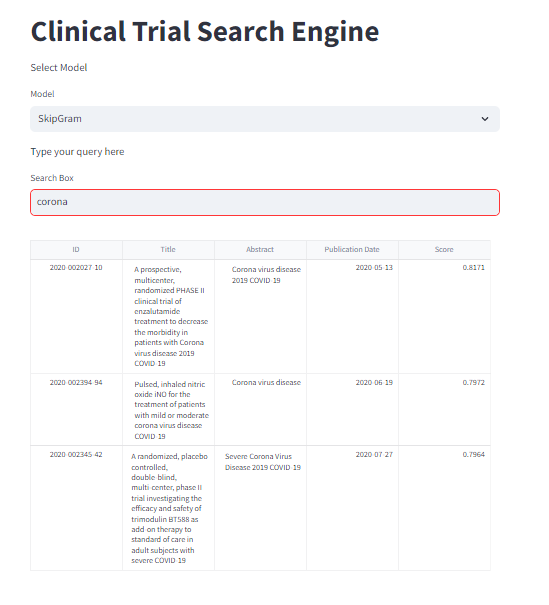

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

- Resources:
    - [Gensim Documentation](https://radimrehurek.com/gensim/auto_examples/index.html)
    
    - [Streamlit documentation](https://docs.streamlit.io/)